# BaZrO3:Ti study

Here are some utility functions and import that will be used throughout the study.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hylight.constants import *

eV1_in_nm = h_c / eV_in_J * 1e9

In [3]:
def best_max(raw_x, raw_y, f=0.95):
    "Fit a 2nd order polynom to get a position of the maximum without the noise."
    guess = np.max(raw_y)

    y = raw_y[raw_y > f * guess]
    x = raw_x[raw_y > f * guess]
    
    x1, x2, x3, x4 = np.mean(x**1), np.mean(x**2), np.mean(x**3), np.mean(x**4)
    
    x2y = np.mean(x**2 * y)
    xy = np.mean(x * y)
    my = np.mean(y)

    A = np.array([[x4, x3, x2],
                  [x3, x2, x1],
                  [x2, x1, 1.]])

    B = np.array([[x2y, xy, my]]).transpose()

    alpha, beta, gamma = np.linalg.solve(A, B)[:, 0]
    
    return -0.5 * beta / alpha, gamma - 0.25 * beta**2 / alpha
    
def load_exp(path, sep=";", skip=0):
    exp = np.loadtxt(path,
                     delimiter=sep,
                    skiprows=skip)
    x, y = eV1_in_nm / exp[:, 0], exp[:, 1]
    xmax, ymax = best_max(x, y)
    y /= ymax
    return x, y, xmax

def select_interval(x, y, emin, emax, norm=True, npoints=None):
    slice_ = (x > emin) * (x < emax)
    xs, ys = x[slice_], y[slice_] / (np.max(y[slice_]) if norm else 1.)
    
    if npoints is not None:
        emin = max(np.min(xs), emin)
        emax = min(np.max(xs), emax)
        xint = np.linspace(emin, emax, npoints)
        return xint, interp1d(xs, ys)(xint)
    
    return xs, ys

To perform the simulation of the spectrum of BaZrO3:Ti we need a few pieces of information.
The following diagram shows the four points A, B, C and D that need to be computed in DFT.
We used constrained DFT to compute B and C with an explicit hole in the VBM and an electron in the CBM.
The cDFT and the regular DFT computations provides us with total energies and the positions $R_G$ and $R_E$ that we will use as inputs in the next section.

![figure_1](./energy_diagram.png "Figure 1: Investigated electronic states")

Given the geometry $R_G$ we also perform a DFPT computation to get the eigen values and eigenvectors of the dynamical matrix, that is we get the $\Gamma$ vibrational modes of the crystal.

The modes are extracted from the VASP output file and stored in the `OUTCAR.npz` with the command line tool `hylight-modes`:
```sh
$ hylight-modes vasp OUTCAR OUTCAR.npz
Loaded 120 modes from OUTCAR.
Wrote OUTCAR.npz.
```

## Vibronic luminescence spectrum

### Electronic and vibrational parameters

Here we declare the inputs that will be used later.

In [4]:
fc_shift_es = 0.1091  # B-C
fc_shift_gs = 0.2871  # D-A
delta_e_em = 2.6905  # C-D

e_adia = delta_e_em + fc_shift_gs  # C-A

outcar = "OUTCAR.npz"  # vibrations
poscar_gs = "POSCAR"  # R_G
poscar_es = "POSCAR_ES"  # R_E
T = 300  # measure temperature (K)

print(f"Adiabatic energy difference: {e_adia:.3} eV")

Adiabatic energy difference: 2.98 eV


### Simulating the spectrum

Here we load the experimental data that will be used for comparision with the simulation.

In [5]:
exp_e, exp_i, max_emission = load_exp("emission_300K.csv", skip=1)

print(f"Measured maximum of emission: {max_emission:.3} eV")

Measured maximum of emission: 2.73 eV


We now plot the spectral function to identify important modes.

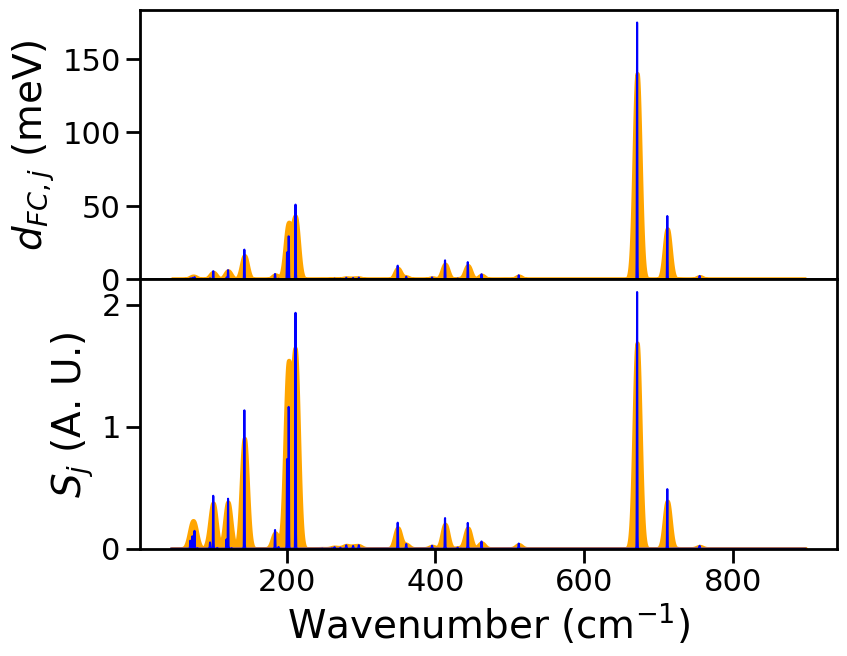

In [6]:
from hylight.multi_phonons import plot_spectral_function

fig, (ax_fc, ax_s) = plot_spectral_function(outcar, poscar_gs, poscar_es, use_cm1=True, disp=5e-1, mpl_params={
    "S_stack": {"color": "orange"},
    "FC_stack": {"color": "orange"},
    "S_peaks": {"color": "blue", "lw": 1.5},
    "FC_peaks": {"color": "blue", "lw": 1.5},
})

ax_fc.set_ylabel("$d_{FC,j}$ (meV)")
ax_s.set_ylabel("$S_j$ (A. U.)")

fig.set_size_inches((9, 7))

We simulate the spectrum using the Mode Independant scaling approximation for the ES PES.

In [7]:
from hylight.multi_phonons import spectrum, ExPES, OmegaEff
import logging

logging.getLogger().setLevel(logging.INFO)  # setting the logging level to INFO

e, sp = spectrum(  # simulate the spectrum
    outcar,
    poscar_gs,
    poscar_es,
    e_adia,
    T,
    fc_shift_gs,
    fc_shift_es,
    ex_pes=ExPES.ISO_SCALE,
    omega_eff_type=OmegaEff.FC_MEAN,
)

sp /= np.max(sp)  # normalize the spectrum

_, max_th = max(zip(sp, e))  # extract the maximum of emission energy
print(f"Computed maximum of emission: {max_th:.3} eV")

d_fc^e,v = 0.15494048765687785
omega_gs = 59.3441936353856 meV 478.64320119276204 cm-1
omega_es = 36.58255313775182 meV 295.0581896729496 cm-1
S_em = 10.055832452822724
d_fc^g,v = 0.407730650836752
FWHM 723.172263202136 meV
FWHM 0K 564.4130957462941 meV


Using a Gaussian line shape.
Computed maximum of emission: 2.71 eV


Finally we setup a plot to show the result of the simulation against the measurement.

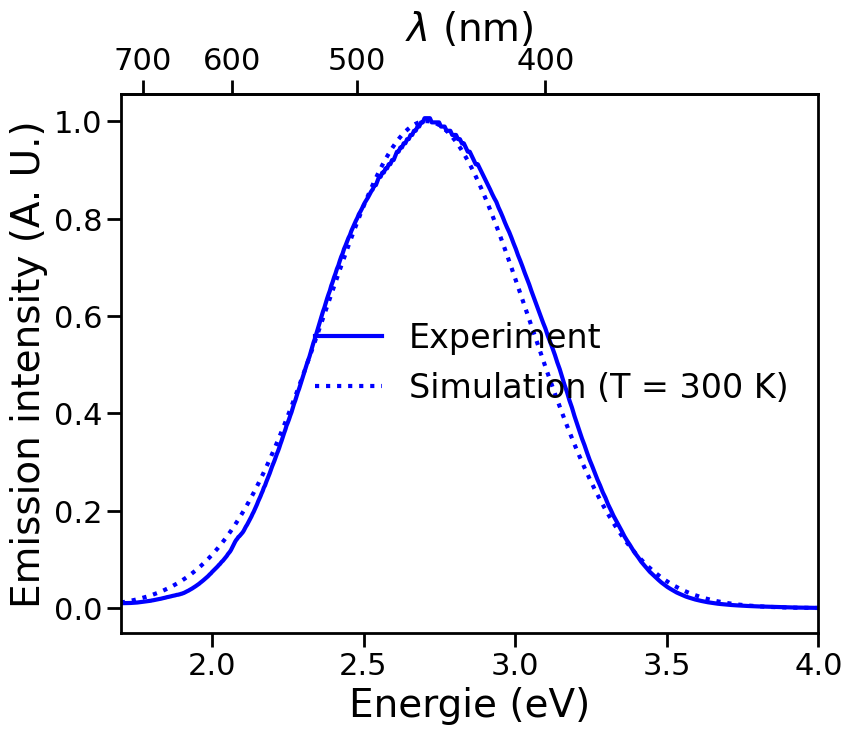

In [8]:
plt.figure(figsize=(9, 7))

e, sp = e[1:], sp[1:]
exp_e, exp_i = exp_e[1:], exp_i[1:]
plt.plot(exp_e, exp_i, "b", lw=3, label="Experiment")
plt.plot(e, sp, ":", color="b", lw=3, label=f"Simulation (T = {T} K)")

plt.xlim(1.7, 4)
plt.xlabel("Energie (eV)")
plt.ylabel("Emission intensity (A. U.)")

ax = plt.gca()
np.seterr(divide='ignore')  # there is a division by zero occuring in the next line but it is irrelevant for our xlim
secax = ax.secondary_xaxis('top', functions=(lambda x: eV1_in_nm / x, lambda x: eV1_in_nm / x))
secax.set_xlabel("$\lambda$ (nm)")

plt.legend(prop={"size": 24})